IMPORTAR LIBRERIAS NECESSARIAS

In [146]:
# --------------------------------------------
# Manejo de datos
# --------------------------------------------
import pandas as pd
import numpy as np
import re

# --------------------------------------------
# Visualización
# --------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# --------------------------------------------
# Preprocesamiento
# --------------------------------------------
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator

# --------------------------------------------
# Modelado
# --------------------------------------------
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# --------------------------------------------
# Selección de características y evaluación
# --------------------------------------------
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, roc_auc_score
)
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.preprocessing import label_binarize

# --------------------------------------------
# Tratamiento del desbalanceo
# --------------------------------------------
from imblearn.over_sampling import SMOTE

# --------------------------------------------
# Supresión de warnings
# --------------------------------------------
import warnings
warnings.filterwarnings('ignore')

# --------------------------------------------
# Configuración opcional
# --------------------------------------------
pd.options.display.max_columns = None


CARGAR LOS DATASETS

In [148]:
df_clinical_baseline = pandas.read_csv("sys4ms_data/sys4ms_clinical_baseline.csv")

df_clinical_baseline_filtered = df_clinical_baseline[df_clinical_baseline["Event Name"] == "Baseline (Arm 1: Sys4MS Mandatory)"]

df_clinical_baseline_filtered = df_clinical_baseline_filtered.drop(columns=["Event Name"]).reset_index(drop=True)


In [149]:
df_cytometry_baseline = pandas.read_csv("sys4ms_data/sys4ms_cytometry_baseline.csv")

df_cytometry_baseline = df_cytometry_baseline.drop(columns=["redcap_event_name"])


In [150]:
df_mri_oct_baseline = pandas.read_csv("sys4ms_data/sys4ms_mri_oct_baseline.csv")
df_mri_oct_baseline = df_mri_oct_baseline.drop(columns=["Event Name"])


In [151]:
df_msgb = pandas.read_csv("sys4ms_data/sys4ms_msgb.csv", sep=' ')
df_msgb.dropna(subset=['ID'], inplace=True)
df_msgb.set_index('ID', inplace=True)
#df_msgb = df_msgb.transpose()
df_msgb_t = df_msgb.T  # Transpones
df_msgb_t = df_msgb_t.reset_index()  # Convierte el índice en columna

df_msgb_t = df_msgb_t[df_msgb_t["index"] != "OR_joined"]

df_msgb_t['index'] = df_msgb_t['index'].str.replace('S', '', regex=False)

In [152]:
df_msgb_hla = pandas.read_csv("sys4ms_data/sys4ms_msgb_hla.csv", sep=' ')
df_msgb_hla.dropna(subset=['ID'], inplace=True)
df_msgb_hla.set_index('ID',inplace=True)
df_msgb_hla_t = df_msgb_hla.transpose()
df_msgb_hla_t = df_msgb_hla_t.reset_index()

df_msgb_hla_t = df_msgb_hla_t[df_msgb_hla_t["index"] != "OR"]

df_msgb_hla_t['index'] = df_msgb_hla_t['index'].str.replace('S', '', regex=False)

In [153]:
df_proteomics_nostim = pandas.read_csv("sys4ms_data/sys4ms_proteomics_nostim.csv")

UNIR TODOS LOS DATASETS EN UNO UNICO, POR ID'S

In [155]:

df_merged_1 = df_clinical_baseline_filtered.merge(df_cytometry_baseline[['internal_id','cytometry_complete']], 
                                       left_on="Redcap Identification number", 
                                       right_on="internal_id", 
                                       how="left")
df_merged_1.drop(columns=["internal_id"], inplace=True)

In [156]:

df_merged_2 = df_merged_1.merge(df_mri_oct_baseline[['Redcap Identification number', 'Complete?', 'Complete?.1']], 
                           left_on="Redcap Identification number", 
                           right_on="Redcap Identification number", 
                           how="left")

In [157]:
df_merged_3 = df_merged_2.merge(df_msgb_t, 
                           left_on="Sys4MS Identification Number", 
                           right_on="index", 
                           how="left")
df_merged_3.drop(columns=["index"], inplace=True)

In [158]:
df_merged_4 = df_merged_3.merge(df_msgb_hla_t, 
                           left_on="Sys4MS Identification Number", 
                           right_on="index", 
                           how="left")
df_merged_4.drop(columns=["index"], inplace=True)

In [159]:
df_merged_5 = df_merged_4.merge(df_proteomics_nostim, 
                           left_on="Sys4MS Identification Number", 
                           right_on="Sys4MS ID", 
                           how="left")
df_merged_5.drop(columns=["Sys4MS ID"], inplace=True)

LIMPIAR DATASET ORIGINAL Y CAMBIAR NOMBRE COLUMNAS

In [161]:
def clean_column_names(df):
    clean_columns = []
    for col in df.columns:
        #Eliminar espacios al inicio/final
        col = col.strip()
        
        #Reemplazar espacios, guiones, puntos y paréntesis por _
        col = re.sub(r'[\s\-\.\(\)\/]+', '_', col)

        #Eliminar caracteres especiales no alfanuméricos
        col = re.sub(r'[^\w_]', '', col)
        
        #Eliminar múltiples _ consecutivos
        col = re.sub(r'_+', '_', col)
        
        #Eliminar _ al inicio/final
        col = col.strip('_')
        
        #Convertir a minúsculas
        col = col.lower()
        
        clean_columns.append(col)
    
    # Asignar los nuevos nombres al DataFrame
    df.columns = clean_columns
    return df

In [162]:

df_join_clean = clean_column_names(df_merged_5)

df_join_clean['previous_treatments'] = df_join_clean['previous_treatments'].replace(
    ['no', 'None', 'None MS specific', 'no treatment', 'no previous treatment'], 'no_treatment'
).fillna('no_treatment')

df_join_clean.drop(columns=['age_of_ms_onset', 'diagnosis_2017', 'onhv_od', 'onhv_os', 'new_t2_lesions', 'pbvc','cytometry_complete','complete','complete_1'], inplace=True)
df_join_clean = df_join_clean[~df_join_clean['sys4ms_identification_number'].isna()]

MOSTRAR VALORES FALTANTES POR COLUMNA


Resumen de valores faltantes:
                         Column  MissingValues  MissingPercentage
0        was_the_edss_confirmed            354          84.285714
1    incident_optic_neuritis_os            352          83.809524
2    incident_optic_neuritis_od            352          83.809524
3       prior_optic_neuritis_os            351          83.571429
4       prior_optic_neuritis_od            351          83.571429
..                          ...            ...                ...
265                  1910592144             21           5.000000
266                  1911173928             21           5.000000
267                  1611114512             21           5.000000
268            age_at_inclusion              3           0.714286
269                  ms_subtype              2           0.476190

[270 rows x 3 columns]


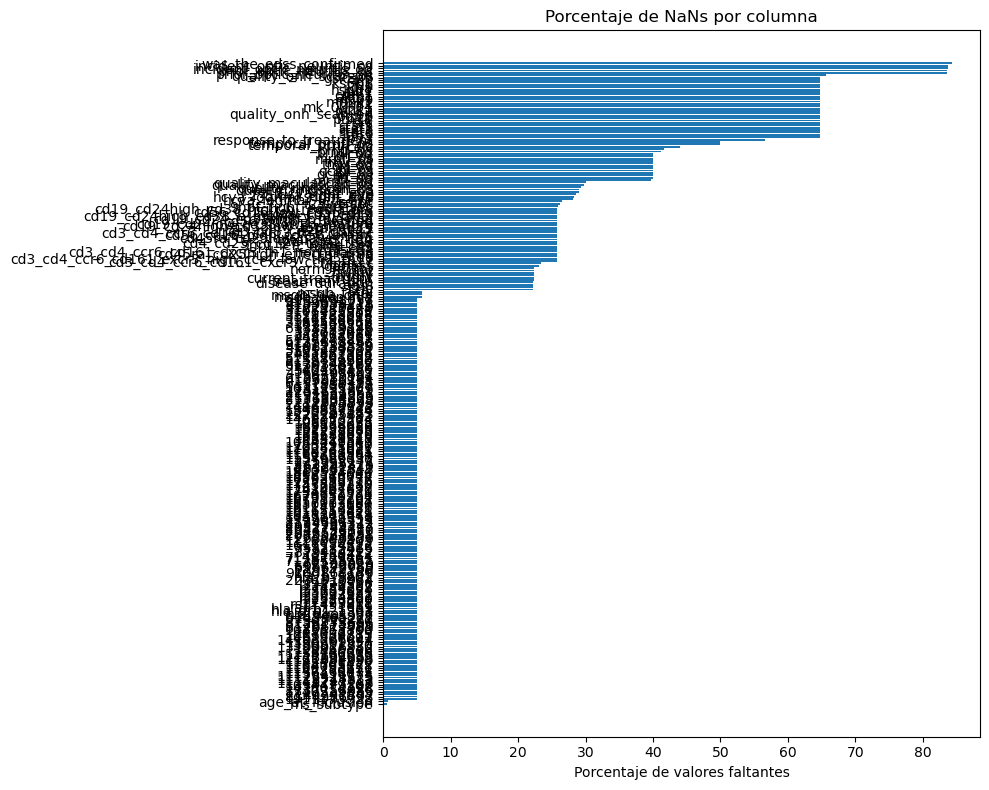

In [164]:
total_rows = len(df_join_clean)
missing_summary = df_join_clean.isnull().sum()
missing_summary = missing_summary[missing_summary > 0].sort_values(ascending=False)

missing_summary_df = missing_summary.reset_index()
missing_summary_df.columns = ['Column', 'MissingValues']
missing_summary_df['MissingPercentage'] = (missing_summary_df['MissingValues'] / total_rows) * 100

print("\nResumen de valores faltantes:")
print(missing_summary_df)

missing_summary_df.to_csv("resumen_valores_faltantes.csv", index=False)

missing_summary_df.sort_values("MissingPercentage", inplace=True)

plt.figure(figsize=(10, 8))
plt.barh(missing_summary_df["Column"], missing_summary_df["MissingPercentage"])
plt.xlabel("Porcentaje de valores faltantes")
plt.title("Porcentaje de NaNs por columna")
plt.tight_layout()
plt.show()


In [165]:
#obviar variables pseudo categoricas y usar msgb_non_hla	msgb_hla_only	msgb_total

In [166]:
# Lista de columnas categóricas clínicas y de escaneo a imputar con 'unknown'
categorical_unknown_columns = [
    'was_the_edss_confirmed',
    'incident_optic_neuritis_od',
    'incident_optic_neuritis_os',
    'prior_optic_neuritis_od',
    'prior_optic_neuritis_os',
    'quality_onh_scan_os', 'quality_onh_scan_od',
    'quality_maculascan_os', 'quality_maculascan_od',
    'quality_ringscan_os', 'quality_ringscan_od'
]

for col in categorical_unknown_columns:
    df_join_clean[col] = df_join_clean[col].fillna('unknown')

df_join_clean['current_treatment'] = df_join_clean['current_treatment'].fillna('No treatment')
df_join_clean['treatment_line'] = df_join_clean['treatment_line'].fillna(0)
df_join_clean['response_to_treatment'] = df_join_clean['response_to_treatment'].fillna('no_information')

# Función para detectar columnas pseudo-categóricas (solo 0, 1, 2 + NaN)
def is_pseudo_categorical(series):
    unique_values = series.dropna().unique()
    return set(unique_values).issubset({0, 1, 2})

# Identificar columnas pseudo-categóricas con NaNs
pseudo_categoricals = [
    col for col in df_join_clean.columns
    if is_pseudo_categorical(df_join_clean[col]) and df_join_clean[col].isnull().any()
]

# Imputar con la moda en columnas pseudo-categóricas
for col in pseudo_categoricals:
    mode_val = df_join_clean[col].mode().iloc[0]
    df_join_clean[col] = df_join_clean[col].fillna(mode_val)

mode_val_celc = df_join_clean['celc'].mode()[0]
df_join_clean['celc'] = df_join_clean['celc'].fillna(mode_val_celc)

In [167]:
# 1. Seleccionar columnas numéricas con NaNs
numeric_cols = df_join_clean.select_dtypes(include=['number']).columns
numeric_with_nan = [col for col in numeric_cols if df_join_clean[col].isnull().any()]

print("\nColumnas numéricas con valores faltantes:")
print(numeric_with_nan)

# 2. Escalar los datos numéricos
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_join_clean[numeric_with_nan])

# 3. Aplicar KNNImputer
imputer = KNNImputer(n_neighbors=5)
imputed_scaled = imputer.fit_transform(scaled_data)

imputed_original = scaler.inverse_transform(imputed_scaled)

df_join_clean[numeric_with_nan] = imputed_original


Columnas numéricas con valores faltantes:
['age_at_inclusion', 'disease_duration', 'edss', 'ugmsss', 'garmss', 't25wt_sec', '9hpt_right_hand_sec', '9hpt_left_hand_sec', 'sdmt', '2_5lcva_right_eye', '2_5lcva_left_eye', 'hcva_logmar_right_eye', 'hcva_logmar_left_eye', 'prnfl_od', 'prnfl_os', 'mrnfl_od', 'mrnfl_os', 'temporal_prnfl_od', 'temporal_prnfl_os', 'tmv_od', 'tmv_os', 'trt_od', 'trt_os', 'gcipl_od', 'gcipl_os', 'inl_od', 'inl_os', 'orl_od', 'orl_os', 't2lc', 't2lv', 'norm_factor', 'nbv', 'nwmv', 'ngmv', 'total_cd3', 'cd3_cd4', 'cd4_cd25_cd127_total_treg', 'cd45ra_cd25low_naive_treg', 'cd45ra_cd25high_effector_treg', 'cd3_cd8', 'cd3_cd8_cd28_cd127', 'total_cd19', 'cd19_cd24high_cd38low_b_memory', 'cd19_cd24low_cd38low_b_mature', 'cd19_cd24high_cd38_high_b_regulatory', 'cd19_cd24_cd38high_b_plasma', 'cd19_cd24high_cd38_b_memory_atypical', 'total_cd3_cd19', 'cd56_cd16_low_cd56_dim', 'cd56_cd16_high_cd_56_bright', 'cd56_cd16_cd56_neg', 'total_cd3_cd4', 'cd3_cd4_ccr6_cd161_cxcr3_th1_

In [168]:
df_join_clean['ms_subtype'] = df_join_clean['ms_subtype'].fillna(df_join_clean['ms_subtype'].mode().iloc[0])

In [169]:
total_rows = len(df_join_clean)
missing_summary = df_join_clean.isnull().sum()
missing_summary = missing_summary[missing_summary > 0].sort_values(ascending=False)

missing_summary_df = missing_summary.reset_index()
missing_summary_df.columns = ['Column', 'MissingValues']
missing_summary_df['MissingPercentage'] = (missing_summary_df['MissingValues'] / total_rows) * 100

print("\nResumen de valores faltantes:")
print(missing_summary_df)


Resumen de valores faltantes:
Empty DataFrame
Columns: [Column, MissingValues, MissingPercentage]
Index: []


In [170]:
df_join_clean.to_csv('df_join_clean.csv', index=False)

In [171]:
df_r = df_join_clean.copy()
df_response = df_join_clean.copy()

In [172]:
# Daclizumab eliminado
# juntamos Ocrelizumab + Rituximab llamamos anti-cd20
print(df_r["current_treatment"].value_counts())

current_treatment
No treatment          189
Interferon             42
Glatiramer acetate     39
Fingolimod             38
Fumarate               36
Natalizumab            29
Teriflunomide          28
Alentuzumab             9
Rituximab               7
Daclizumab              2
Ocrelizumab             1
Name: count, dtype: int64


MODELO RANDOM FOREST CLASSIFIER

Accuracy: 0.5106382978723404

Reporte de clasificación:
                     precision    recall  f1-score   support

       Alentuzumab       1.00      1.00      1.00         1
        Fingolimod       0.62      0.62      0.62         8
          Fumarate       0.67      0.36      0.47        11
Glatiramer acetate       0.46      0.60      0.52        10
        Interferon       0.27      0.50      0.35         6
       Natalizumab       0.67      0.80      0.73         5
       Ocrelizumab       0.00      0.00      0.00         1
         Rituximab       0.00      0.00      0.00         1
     Teriflunomide       0.50      0.25      0.33         4

          accuracy                           0.51        47
         macro avg       0.47      0.46      0.45        47
      weighted avg       0.53      0.51      0.50        47



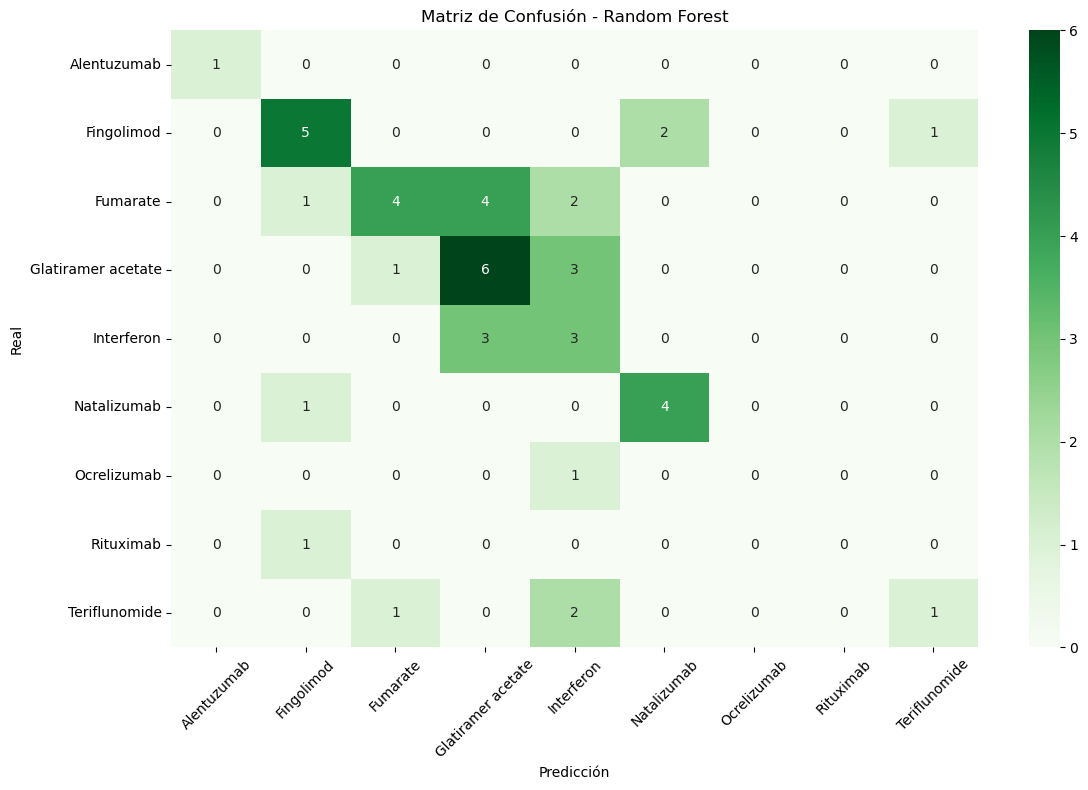

In [174]:
df_with_treatment = df_r[df_r["current_treatment"] != "No treatment"].copy()
df_without_treatment = df_r[df_r["current_treatment"] == "No treatment"].copy()

target = 'current_treatment'
drop_columns = ['redcap_identification_number', 'sys4ms_identification_number', target]
X = df_with_treatment.drop(columns=drop_columns)
y = df_with_treatment[target]

# Identificar columnas numéricas y categóricas
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Paso 4: Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocesor usado:
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])

# Pipeline para RandomForestClassifier:
pipeline_RF = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(random_state=42))
])

# Entrenar el modelo
pipeline_RF.fit(X_train, y_train)

# Evaluar el modelo
y_pred = pipeline_RF.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nReporte de clasificación:\n", classification_report(y_test, y_pred, zero_division=0))

# Obtener los labels
labels = sorted(set(y_test) | set(y_pred))

plt.figure(figsize=(12, 8))
sns.heatmap(
    confusion_matrix(y_test, y_pred),
    annot=True,
    fmt='d',
    cmap='Greens',
    xticklabels=labels,
    yticklabels=labels
)
plt.title('Matriz de Confusión - Random Forest')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

MODELO RANDOM FOREST CLASSIFIER (BALANCED)

Accuracy: 0.5319148936170213

Reporte de clasificación:
                     precision    recall  f1-score   support

       Alentuzumab       1.00      1.00      1.00         1
        Fingolimod       0.78      0.88      0.82         8
          Fumarate       0.57      0.36      0.44        11
Glatiramer acetate       0.56      0.50      0.53        10
        Interferon       0.20      0.33      0.25         6
       Natalizumab       1.00      0.80      0.89         5
       Ocrelizumab       0.00      0.00      0.00         1
         Rituximab       0.50      1.00      0.67         1
     Teriflunomide       0.20      0.25      0.22         4

          accuracy                           0.53        47
         macro avg       0.53      0.57      0.54        47
      weighted avg       0.57      0.53      0.54        47



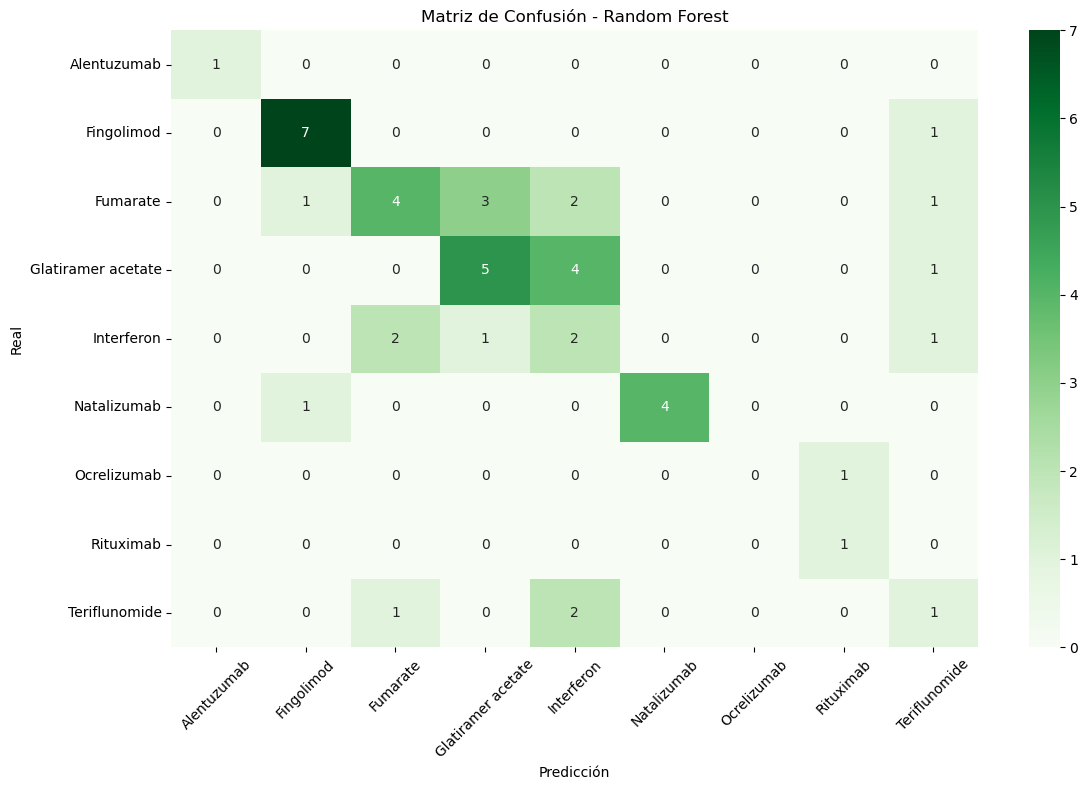

Clase 'Daclizumab' no está presente en y_test. Se omite en ROC.


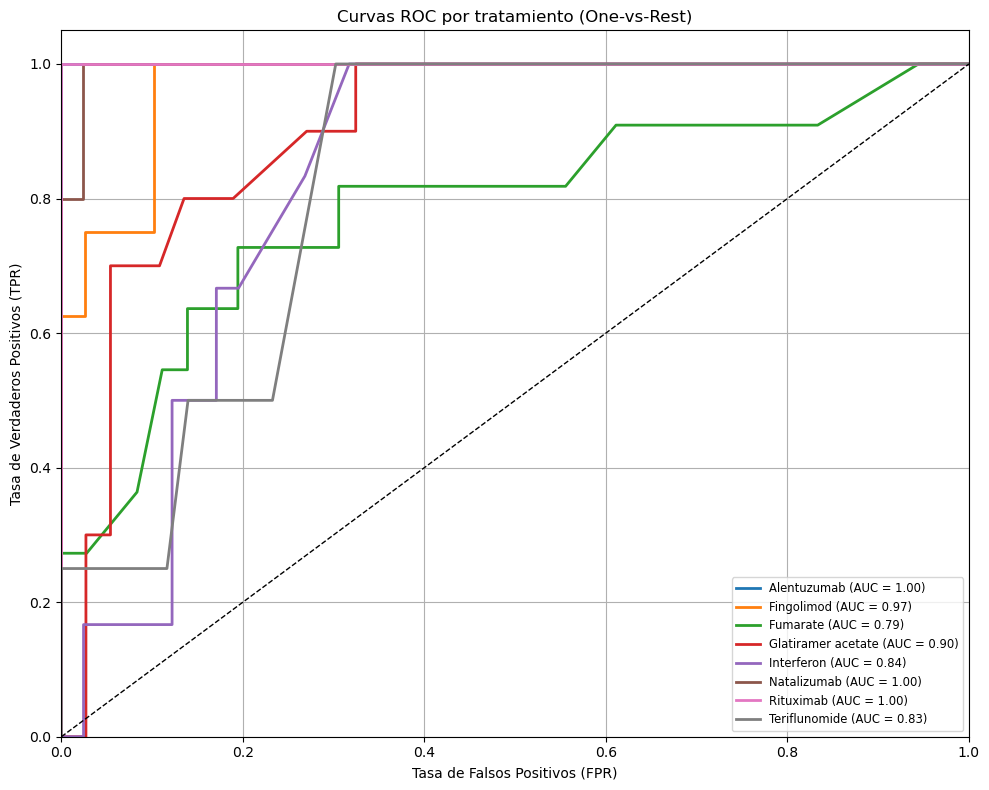

In [176]:
df_r = df_join_clean.copy()

df_with_treatment = df_r[df_r["current_treatment"] != "No treatment"].copy()
df_without_treatment = df_r[df_r["current_treatment"] == "No treatment"].copy()


target = 'current_treatment'
drop_columns = ['redcap_identification_number', 'sys4ms_identification_number', target]
X = df_with_treatment.drop(columns=drop_columns)
y = df_with_treatment[target]


num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])


pipeline_RFW = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(random_state=42, class_weight='balanced'))
])


pipeline_RFW.fit(X_train, y_train)


y_pred = pipeline_RFW.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nReporte de clasificación:\n", classification_report(y_test, y_pred, zero_division=0))

labels = sorted(set(y_test) | set(y_pred))

plt.figure(figsize=(12, 8))
sns.heatmap(
    confusion_matrix(y_test, y_pred),
    annot=True,
    fmt='d',
    cmap='Greens',
    xticklabels=labels,
    yticklabels=labels
)
plt.title('Matriz de Confusión - Random Forest')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

classes = pipeline_RFW.named_steps["classifier"].classes_
y_test_bin = label_binarize(y_test, classes=classes)
n_classes = y_test_bin.shape[1]

y_score = pipeline_RFW.predict_proba(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    # Evitar clases ausentes en y_test
    if np.sum(y_test_bin[:, i]) == 0:
        print(f"Clase '{classes[i]}' no está presente en y_test. Se omite en ROC.")
        continue

    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Graficar curvas ROC
plt.figure(figsize=(10, 8))
for i in roc_auc:
    plt.plot(fpr[i], tpr[i], lw=2, label=f'{classes[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC por tratamiento (One-vs-Rest)')
plt.legend(loc="lower right", fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()


MODELO XGB CLASSIFIER

In [178]:
print(y.value_counts())


current_treatment
Interferon            42
Glatiramer acetate    39
Fingolimod            38
Fumarate              36
Natalizumab           29
Teriflunomide         28
Alentuzumab            9
Rituximab              7
Daclizumab             2
Ocrelizumab            1
Name: count, dtype: int64


Clases eliminadas por tener menos de 2 casos:
current_treatment
Ocrelizumab    1
Name: count, dtype: int64
Accuracy: 0.6739130434782609

Reporte de clasificación:
                     precision    recall  f1-score   support

       Alentuzumab       0.50      0.50      0.50         2
        Fingolimod       0.78      0.88      0.82         8
          Fumarate       0.62      0.71      0.67         7
Glatiramer acetate       0.62      0.62      0.62         8
        Interferon       0.50      0.75      0.60         8
       Natalizumab       1.00      1.00      1.00         6
         Rituximab       0.00      0.00      0.00         1
     Teriflunomide       1.00      0.17      0.29         6

          accuracy                           0.67        46
         macro avg       0.63      0.58      0.56        46
      weighted avg       0.71      0.67      0.65        46



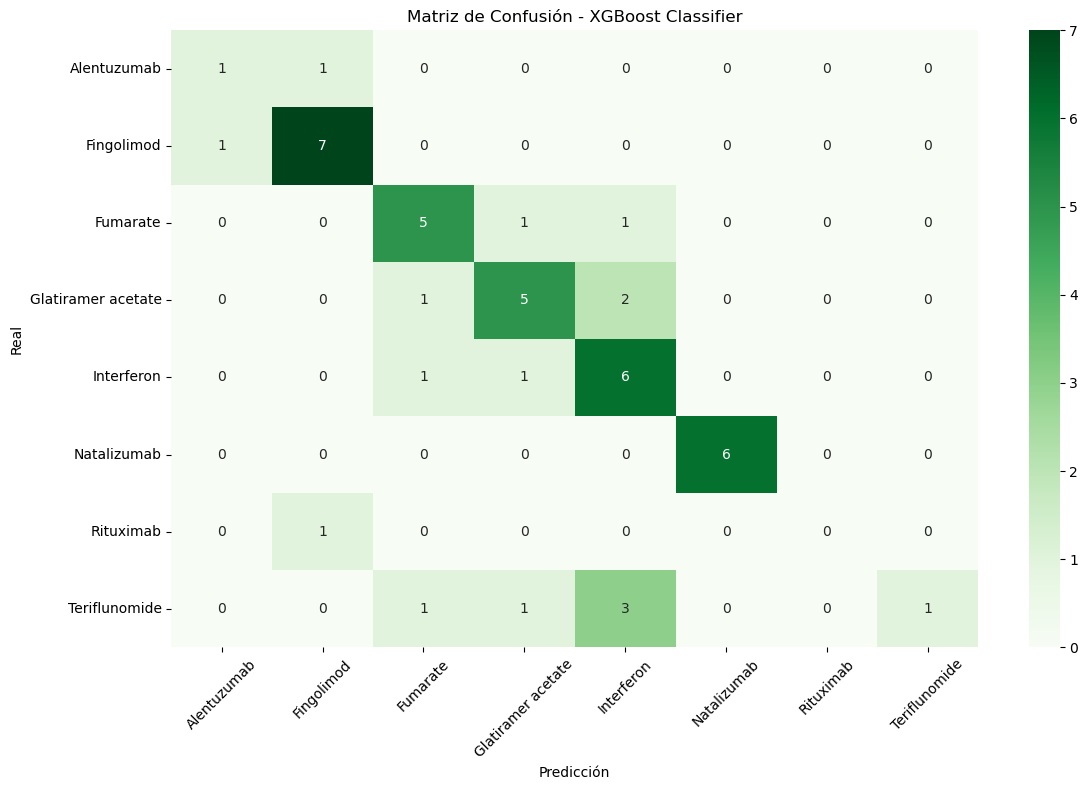

In [179]:
df_with_treatment = df_r[df_r["current_treatment"] != "No treatment"].copy()
df_without_treatment = df_r[df_r["current_treatment"] == "No treatment"].copy()


target = 'current_treatment'
drop_columns = ['redcap_identification_number', 'sys4ms_identification_number', target]
X = df_with_treatment.drop(columns=drop_columns)
y = df_with_treatment[target]

# Ver clases eliminadas
removed_classes = y.value_counts()[y.value_counts() < 2]
if not removed_classes.empty:
    print("Clases eliminadas por tener menos de 2 casos:")
    print(removed_classes)
else:
    print("Todas las clases tienen al menos 2 casos.")

valid_classes = y.value_counts()[y.value_counts() >= 2].index
X = X[y.isin(valid_classes)]
y = y[y.isin(valid_classes)]

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, stratify=y_encoded, test_size=0.2, random_state=42)

# Preprocesor usado:
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])

# Pipeline para XGBClassifier:
pipeline_XGB = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", XGBClassifier(
        objective='multi:softprob',
        num_class=len(y.unique()),
        eval_metric='mlogloss',
        use_label_encoder=False,
        random_state=42
    ))
])


pipeline_XGB.fit(X_train, y_train)

y_pred = pipeline_XGB.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

y_test_labels = label_encoder.inverse_transform(y_test)
y_pred_labels = label_encoder.inverse_transform(y_pred)

print("\nReporte de clasificación:\n", classification_report(y_test_labels, y_pred_labels, zero_division=0))

# Matriz de confusión
labels = sorted(set(y_test_labels) | set(y_pred_labels))
plt.figure(figsize=(12, 8))
sns.heatmap(
    confusion_matrix(y_test_labels, y_pred_labels, labels=labels),
    annot=True,
    fmt='d',
    cmap='Greens',
    xticklabels=labels,
    yticklabels=labels
)
plt.title('Matriz de Confusión - XGBoost Classifier')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

MODELO XGB CLASSIFIER (BALANCED WEIGHTS)

Clases eliminadas por tener menos de 2 casos:
current_treatment
Ocrelizumab    1
Name: count, dtype: int64
Accuracy: 0.7391304347826086

Reporte de clasificación:
                     precision    recall  f1-score   support

       Alentuzumab       0.67      1.00      0.80         2
        Fingolimod       0.88      0.88      0.88         8
          Fumarate       0.67      0.57      0.62         7
Glatiramer acetate       0.67      0.75      0.71         8
        Interferon       0.55      0.75      0.63         8
       Natalizumab       1.00      1.00      1.00         6
         Rituximab       1.00      1.00      1.00         1
     Teriflunomide       1.00      0.33      0.50         6

          accuracy                           0.74        46
         macro avg       0.80      0.78      0.77        46
      weighted avg       0.78      0.74      0.73        46



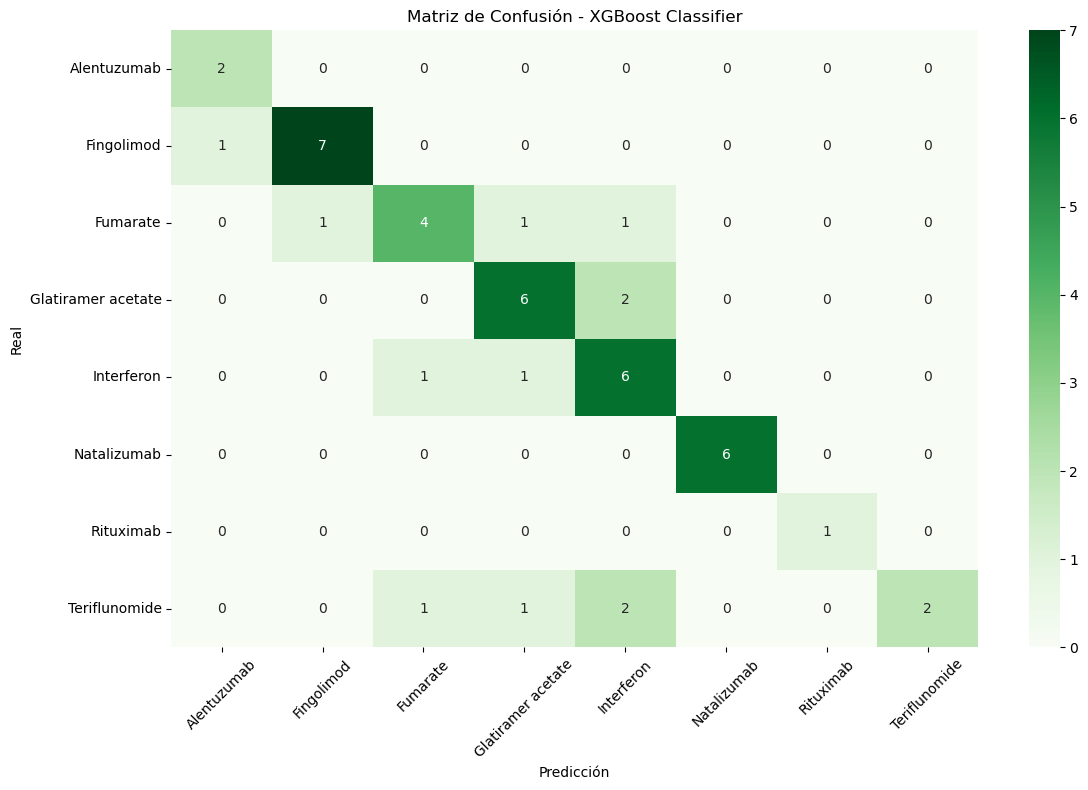

 Clase 'Daclizumab' no está presente en y_test. Se omite en ROC.


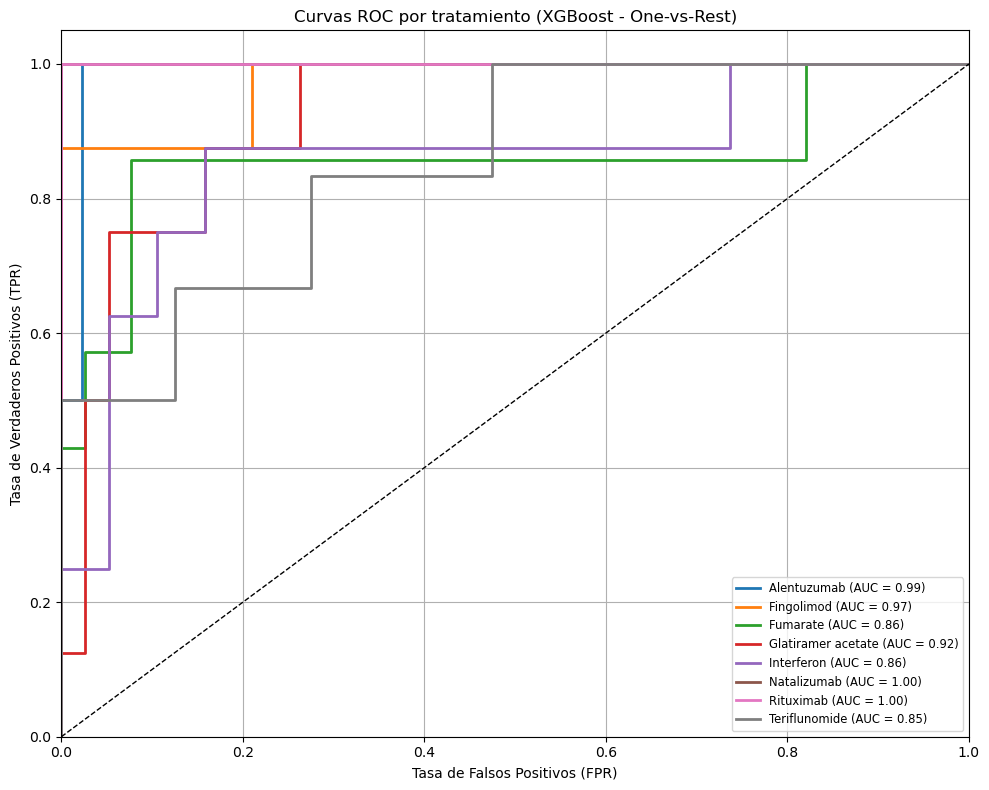

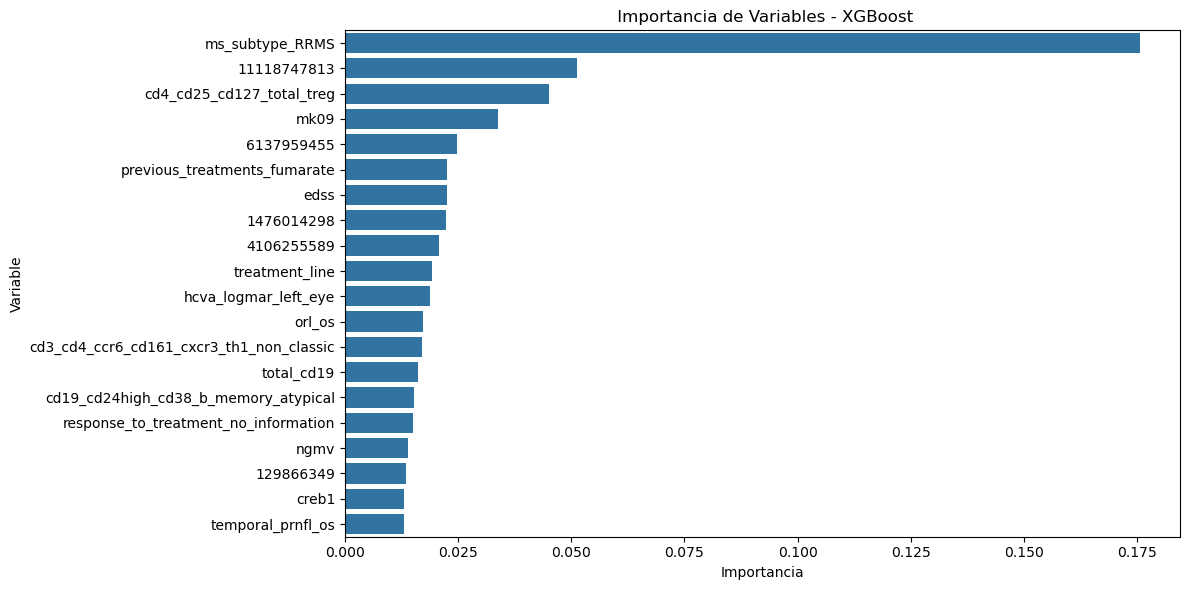

In [181]:
df_with_treatment = df_r[df_r["current_treatment"] != "No treatment"].copy()
df_without_treatment = df_r[df_r["current_treatment"] == "No treatment"].copy()


target = 'current_treatment'
drop_columns = ['redcap_identification_number', 'sys4ms_identification_number', target]
X = df_with_treatment.drop(columns=drop_columns)
y = df_with_treatment[target]


removed_classes = y.value_counts()[y.value_counts() < 2]
if not removed_classes.empty:
    print("Clases eliminadas por tener menos de 2 casos:")
    print(removed_classes)
else:
    print("Todas las clases tienen al menos 2 casos.")

valid_classes = y.value_counts()[y.value_counts() >= 2].index
X = X[y.isin(valid_classes)]
y = y[y.isin(valid_classes)]

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()


X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, stratify=y_encoded, test_size=0.2, random_state=42)

# Preprocesor usado:
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])

# Pipeline para XGBClassifier:
pipeline_XGB = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", XGBClassifier(
        objective='multi:softprob',
        num_class=len(y.unique()),
        eval_metric='mlogloss',
        use_label_encoder=False,
        random_state=42
    ))
])

# Calcular pesos para el set de entrenamiento
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

pipeline_XGB.fit(X_train, y_train, classifier__sample_weight=sample_weights)

y_pred = pipeline_XGB.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

y_test_labels = label_encoder.inverse_transform(y_test)
y_pred_labels = label_encoder.inverse_transform(y_pred)

print("\nReporte de clasificación:\n", classification_report(y_test_labels, y_pred_labels, zero_division=0))

# Matriz de confusión
labels = sorted(set(y_test_labels) | set(y_pred_labels))
plt.figure(figsize=(12, 8))
sns.heatmap(
    confusion_matrix(y_test_labels, y_pred_labels, labels=labels),
    annot=True,
    fmt='d',
    cmap='Greens',
    xticklabels=labels,
    yticklabels=labels
)
plt.title('Matriz de Confusión - XGBoost Classifier')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

classes = label_encoder.classes_

y_test_bin = label_binarize(y_test, classes=range(len(classes)))
y_score = pipeline_XGB.predict_proba(X_test)
n_classes = y_test_bin.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    if np.sum(y_test_bin[:, i]) == 0:
        print(f" Clase '{classes[i]}' no está presente en y_test. Se omite en ROC.")
        continue
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Graficar curvas ROC
plt.figure(figsize=(10, 8))
for i in roc_auc:
    plt.plot(fpr[i], tpr[i], lw=2, label=f'{classes[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC por tratamiento (XGBoost - One-vs-Rest)')
plt.legend(loc="lower right", fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()


xgb_model = pipeline_XGB.named_steps["classifier"]

ohe = pipeline_XGB.named_steps["preprocessor"].named_transformers_["cat"]
ohe_feature_names = ohe.get_feature_names_out(cat_cols)


feature_names = num_cols + list(ohe_feature_names)

importances = xgb_model.feature_importances_
importance_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

# 4. Visualizar
plt.figure(figsize=(12, 6))
sns.barplot(x="importance", y="feature", data=importance_df.head(20))  # Top 20
plt.title(" Importancia de Variables - XGBoost")
plt.xlabel("Importancia")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()

XGB CON SLECT FROM MODEL

Clases eliminadas por tener menos de 2 casos:
current_treatment
Ocrelizumab    1
Name: count, dtype: int64
 Variables seleccionadas (104):
['age_at_inclusion' 'treatment_line' 'disease_duration' 'ugmsss' 'garmss'
 't25wt_sec' '9hpt_right_hand_sec' 'sdmt' '2_5lcva_right_eye'
 'hcva_logmar_right_eye' 'prnfl_od' 'mrnfl_od' 'mrnfl_os'
 'temporal_prnfl_od' 'temporal_prnfl_os' 'tmv_od' 'tmv_os' 'gcipl_od'
 'gcipl_os' 'inl_od' 'inl_os' 'orl_od' 'orl_os' 't2lc' 'norm_factor' 'nbv'
 'nwmv' 'ngmv' 'total_cd3' 'cd3_cd4' 'cd4_cd25_cd127_total_treg'
 'cd45ra_cd25low_naive_treg' 'cd45ra_cd25high_effector_treg' 'cd3_cd8'
 'cd3_cd8_cd28_cd127' 'total_cd19' 'cd19_cd24high_cd38low_b_memory'
 'cd19_cd24low_cd38low_b_mature' 'cd19_cd24high_cd38_high_b_regulatory'
 'cd19_cd24_cd38high_b_plasma' 'cd19_cd24high_cd38_b_memory_atypical'
 'total_cd3_cd19' 'cd56_cd16_low_cd56_dim' 'cd56_cd16_high_cd_56_bright'
 'cd56_cd16_cd56_neg' 'total_cd3_cd4'
 'cd3_cd4_ccr6_cd161_cxcr3_th1_classic'
 'cd3_cd4_ccr6_cd161_cxcr

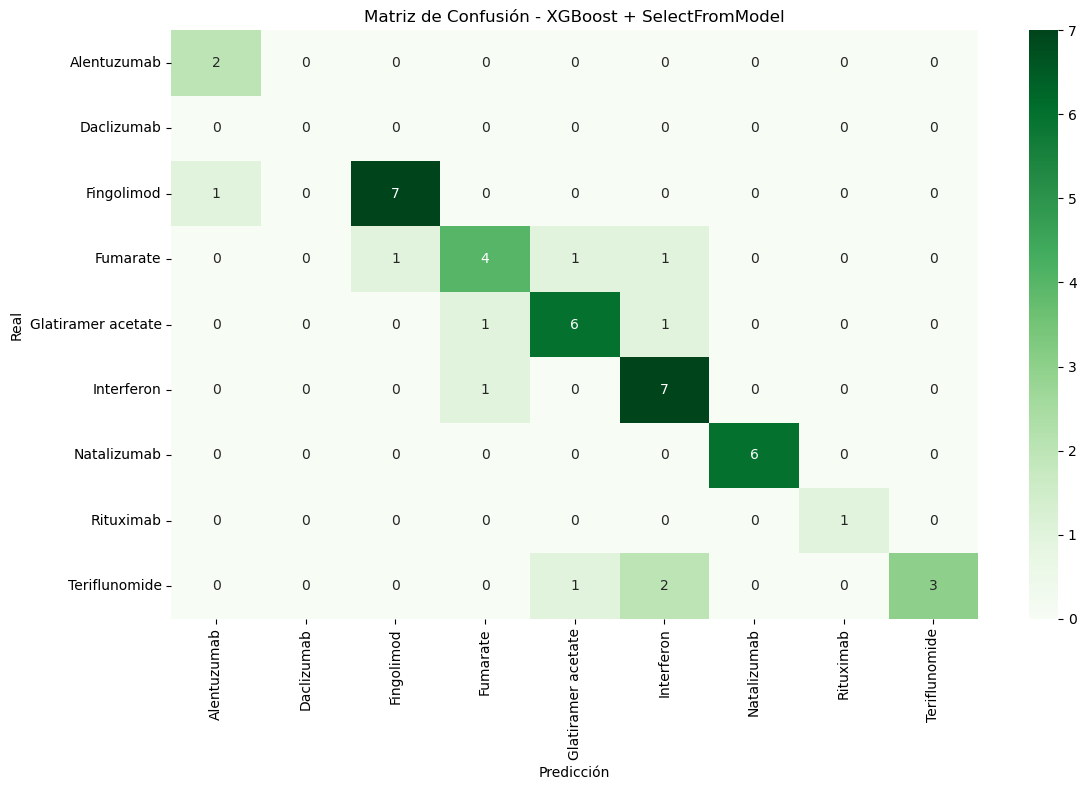

In [183]:
df_with_treatment = df_r[df_r["current_treatment"] != "No treatment"].copy()
df_without_treatment = df_r[df_r["current_treatment"] == "No treatment"].copy()


target = 'current_treatment'
drop_columns = ['redcap_identification_number', 'sys4ms_identification_number', target]
X = df_with_treatment.drop(columns=drop_columns)
y = df_with_treatment[target]


removed_classes = y.value_counts()[y.value_counts() < 2]
if not removed_classes.empty:
    print("Clases eliminadas por tener menos de 2 casos:")
    print(removed_classes)
else:
    print("Todas las clases tienen al menos 2 casos.")

valid_classes = y.value_counts()[y.value_counts() >= 2].index
X = X[y.isin(valid_classes)]
y = y[y.isin(valid_classes)]

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()


X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, stratify=y_encoded, test_size=0.2, random_state=42)


# Preprocesor usado:
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

ohe = preprocessor.named_transformers_["cat"]
ohe_feature_names = ohe.get_feature_names_out(cat_cols)
feature_names = num_cols + list(ohe_feature_names)

# Entrenar modelo base para selección
xgb_model = XGBClassifier(
    objective='multi:softprob',
    num_class=len(label_encoder.classes_),
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)

xgb_model.fit(X_train_processed, y_train)

selector = SelectFromModel(xgb_model, threshold="mean", prefit=True)
X_train_selected = selector.transform(X_train_processed)
X_test_selected = selector.transform(X_test_processed)

# Obtener nombres de las variables seleccionadas
selected_feature_names = np.array(feature_names)[selector.get_support()]
print(f" Variables seleccionadas ({len(selected_feature_names)}):")
print(selected_feature_names)



sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)
xgb_model.fit(X_train_selected, y_train, sample_weight=sample_weights)

# Predicciones
y_pred = xgb_model.predict(X_test_selected)
y_test_labels = label_encoder.inverse_transform(y_test)
y_pred_labels = label_encoder.inverse_transform(y_pred)

print(" Accuracy:", accuracy_score(y_test, y_pred))
print("\n Reporte de clasificación:\n", classification_report(y_test_labels, y_pred_labels, zero_division=0))

# Matriz de confusión
plt.figure(figsize=(12, 8))
sns.heatmap(
    confusion_matrix(y_test_labels, y_pred_labels, labels=sorted(label_encoder.classes_)),
    annot=True,
    fmt='d',
    cmap='Greens',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)
plt.title('Matriz de Confusión - XGBoost + SelectFromModel')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.tight_layout()
plt.show()


In [184]:

# Clases presentes en y_test
present_classes = np.unique(y_test)

# Binarizar solo con las clases presentes
y_test_bin = label_binarize(y_test, classes=present_classes)

# Predecir probabilidades
y_proba = xgb_model.predict_proba(X_test_selected)

# Filtrar columnas de probabilidades correspondientes a las clases presentes
y_proba_present = y_proba[:, present_classes]

# Calcular AUC solo con esas clases
auc_macro = roc_auc_score(y_test_bin, y_proba_present, average='macro')
auc_weighted = roc_auc_score(y_test_bin, y_proba_present, average='weighted')

print(f"\n AUC macro (OVR): {auc_macro:.4f}")
print(f" AUC weighted (OVR): {auc_weighted:.4f}")



 AUC macro (OVR): 0.9372
 AUC weighted (OVR): 0.9225


 Accuracy: 0.6739130434782609

 Reporte de clasificación:
                     precision    recall  f1-score   support

       Alentuzumab       1.00      0.50      0.67         2
        Fingolimod       0.75      0.75      0.75         8
          Fumarate       0.67      0.57      0.62         7
Glatiramer acetate       0.75      0.75      0.75         8
        Interferon       0.54      0.88      0.67         8
       Natalizumab       0.71      0.83      0.77         6
         Rituximab       1.00      1.00      1.00         1
     Teriflunomide       0.50      0.17      0.25         6

          accuracy                           0.67        46
         macro avg       0.74      0.68      0.68        46
      weighted avg       0.68      0.67      0.65        46



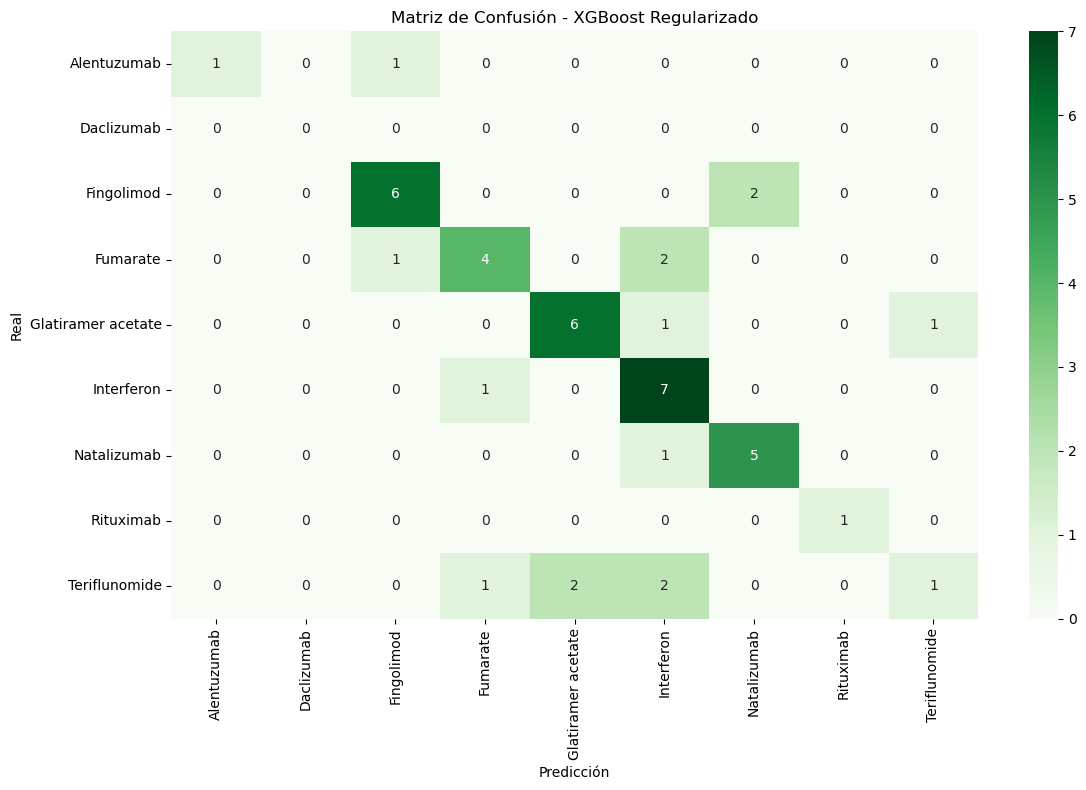

In [185]:

xgb_reg = XGBClassifier(
    
    max_depth=4,              # Limita la profundidad → árboles menos complejos, menos sobreajuste
    min_child_weight=3,       # Mínimo de muestras para hacer una división → evita divisiones innecesarias

    
    reg_lambda=2.0,           # Regularización L2 (penaliza grandes pesos → estabilidad)
    reg_alpha=1.0,            # Regularización L1 (elimina características irrelevantes → sparsity)

    
    subsample=0.8,            # Fracción de filas usadas por cada árbol → evita dependencia total en los datos
    colsample_bytree=0.8,     # Fracción de columnas usadas por árbol → evita dependencia de variables específicas

    
    objective='multi:softprob',   # Multiclase con probabilidades
    eval_metric='mlogloss',       # Pérdida logarítmica multiclase
    use_label_encoder=False,      # Evita warning en nuevas versiones

    
    random_state=42,

    
    num_class=len(label_encoder.classes_)
)

sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)
xgb_reg.fit(X_train_selected, y_train, sample_weight=sample_weights)

y_pred = xgb_reg.predict(X_test_selected)

y_pred_labels = label_encoder.inverse_transform(y_pred)
y_test_labels = label_encoder.inverse_transform(y_test)

print(" Accuracy:", accuracy_score(y_test, y_pred))
print("\n Reporte de clasificación:\n", classification_report(y_test_labels, y_pred_labels, zero_division=0))

# Matriz de confusión
plt.figure(figsize=(12, 8))
sns.heatmap(
    confusion_matrix(y_test_labels, y_pred_labels, labels=sorted(label_encoder.classes_)),
    annot=True,
    fmt='d',
    cmap='Greens',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)
plt.title('Matriz de Confusión - XGBoost Regularizado')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.tight_layout()
plt.show()


Clases eliminadas por tener menos de 2 casos:
current_treatment
Ocrelizumab    1
Name: count, dtype: int64
 Accuracy: 0.7391304347826086

 Reporte de clasificación:
                     precision    recall  f1-score   support

       Alentuzumab       1.00      0.50      0.67         2
        Fingolimod       0.88      0.88      0.88         8
          Fumarate       0.62      0.71      0.67         7
Glatiramer acetate       0.67      0.75      0.71         8
        Interferon       0.60      0.75      0.67         8
       Natalizumab       0.86      1.00      0.92         6
         Rituximab       1.00      1.00      1.00         1
     Teriflunomide       1.00      0.33      0.50         6

          accuracy                           0.74        46
         macro avg       0.83      0.74      0.75        46
      weighted avg       0.78      0.74      0.73        46



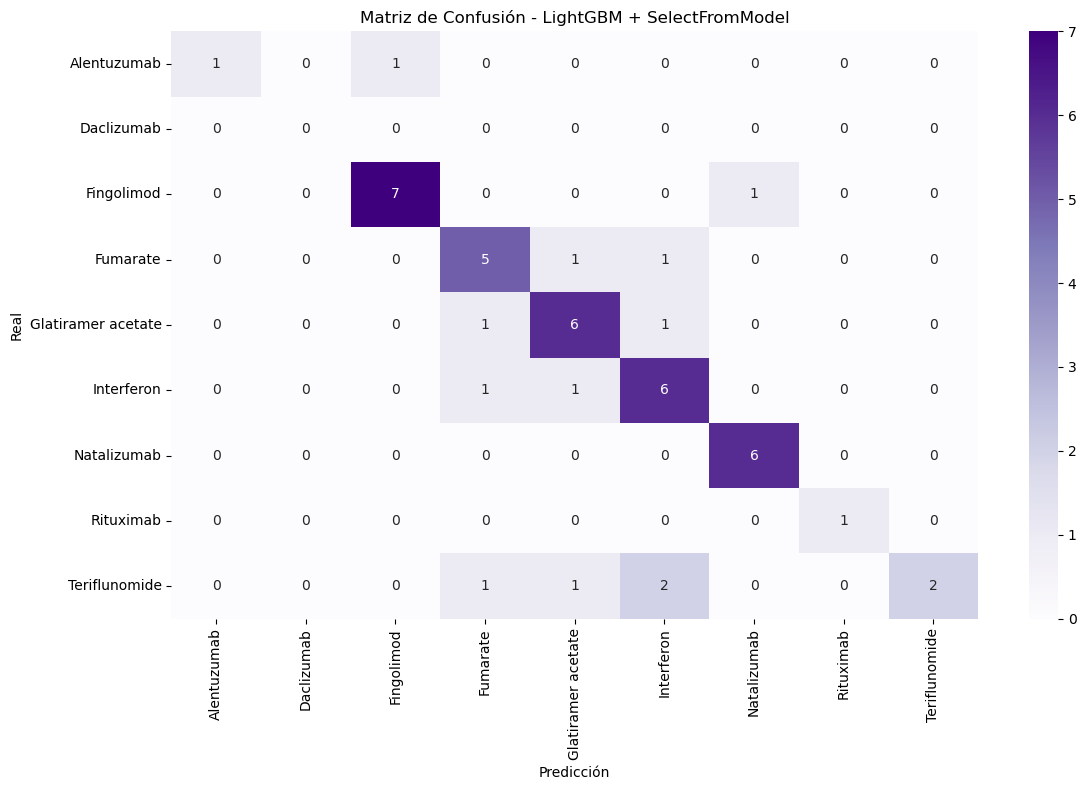

In [186]:
df_with_treatment = df_r[df_r["current_treatment"] != "No treatment"].copy()
df_without_treatment = df_r[df_r["current_treatment"] == "No treatment"].copy()


target = 'current_treatment'
drop_columns = ['redcap_identification_number', 'sys4ms_identification_number', target]
X = df_with_treatment.drop(columns=drop_columns)
y = df_with_treatment[target]


removed_classes = y.value_counts()[y.value_counts() < 2]
if not removed_classes.empty:
    print("Clases eliminadas por tener menos de 2 casos:")
    print(removed_classes)
else:
    print("Todas las clases tienen al menos 2 casos.")

valid_classes = y.value_counts()[y.value_counts() >= 2].index
X = X[y.isin(valid_classes)]
y = y[y.isin(valid_classes)]

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()


X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, stratify=y_encoded, test_size=0.2, random_state=42)


# Preprocesor usado:
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

ohe = preprocessor.named_transformers_["cat"]
ohe_feature_names = ohe.get_feature_names_out(cat_cols)
feature_names = num_cols + list(ohe_feature_names)


lgb_model_base = LGBMClassifier(
    objective='multiclass',
    num_class=len(label_encoder.classes_),
    random_state=42
)

sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)
lgb_model_base.fit(X_train_processed, y_train, sample_weight=sample_weights)

selector_lgb = SelectFromModel(estimator=lgb_model_base, threshold="mean", prefit=True)
X_train_lgb_selected = selector_lgb.transform(X_train_processed)
X_test_lgb_selected = selector_lgb.transform(X_test_processed)

lgb_model_refined = LGBMClassifier(
    objective='multiclass',
    num_class=len(label_encoder.classes_),
    random_state=42,
    verbose=-1
)

lgb_model_refined.fit(X_train_lgb_selected, y_train, sample_weight=sample_weights)

y_pred = lgb_model_refined.predict(X_test_lgb_selected)
y_test_labels = label_encoder.inverse_transform(y_test)
y_pred_labels = label_encoder.inverse_transform(y_pred)

print(" Accuracy:", accuracy_score(y_test, y_pred))
print("\n Reporte de clasificación:\n", classification_report(y_test_labels, y_pred_labels, zero_division=0))

plt.figure(figsize=(12, 8))
sns.heatmap(
    confusion_matrix(y_test_labels, y_pred_labels, labels=sorted(label_encoder.classes_)),
    annot=True,
    fmt='d',
    cmap='Purples',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)
plt.title('Matriz de Confusión - LightGBM + SelectFromModel')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.tight_layout()
plt.show()


Clases eliminadas por tener menos de 2 casos:
current_treatment
Ocrelizumab    1
Name: count, dtype: int64
 Accuracy: 0.7391304347826086

 Reporte de clasificación:
                     precision    recall  f1-score   support

       Alentuzumab       0.67      1.00      0.80         2
        Fingolimod       1.00      0.88      0.93         8
          Fumarate       0.57      0.57      0.57         7
Glatiramer acetate       0.62      0.62      0.62         8
        Interferon       0.55      0.75      0.63         8
       Natalizumab       1.00      1.00      1.00         6
         Rituximab       1.00      1.00      1.00         1
     Teriflunomide       1.00      0.50      0.67         6

          accuracy                           0.74        46
         macro avg       0.80      0.79      0.78        46
      weighted avg       0.78      0.74      0.74        46



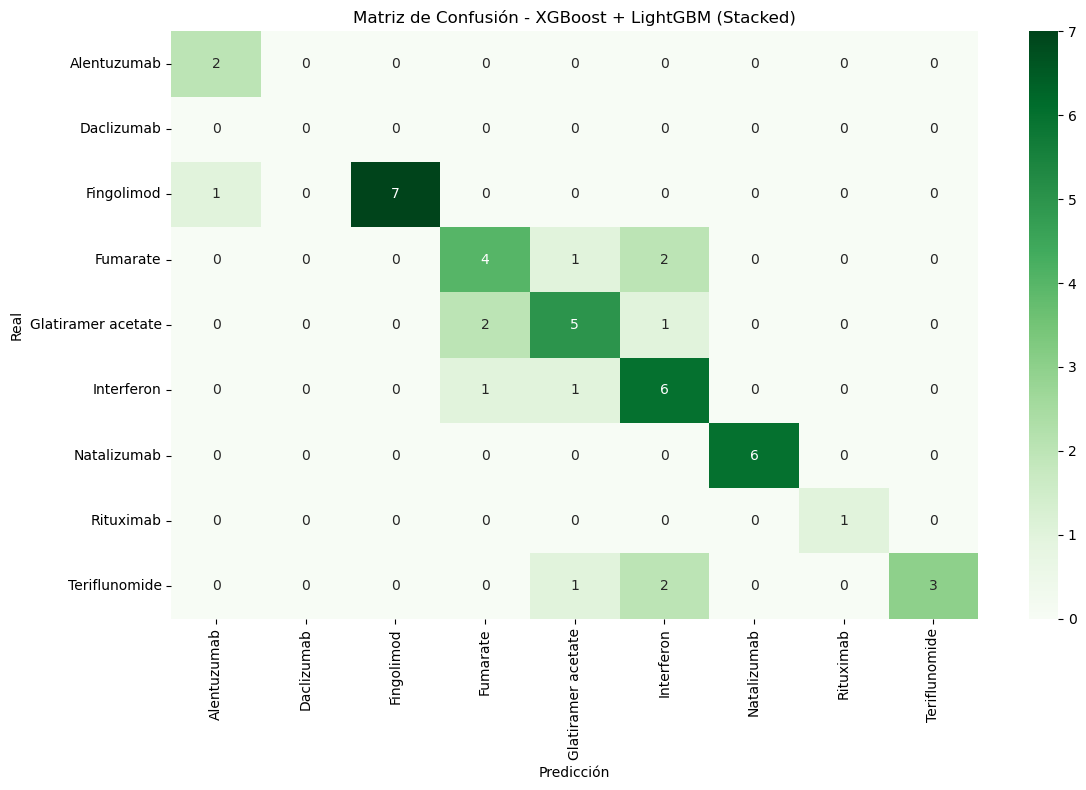

In [187]:
df_with_treatment = df_r[df_r["current_treatment"] != "No treatment"].copy()
df_without_treatment = df_r[df_r["current_treatment"] == "No treatment"].copy()


target = 'current_treatment'
drop_columns = ['redcap_identification_number', 'sys4ms_identification_number', target]
X = df_with_treatment.drop(columns=drop_columns)
y = df_with_treatment[target]


removed_classes = y.value_counts()[y.value_counts() < 2]
if not removed_classes.empty:
    print("Clases eliminadas por tener menos de 2 casos:")
    print(removed_classes)
else:
    print("Todas las clases tienen al menos 2 casos.")


valid_classes = y.value_counts()[y.value_counts() >= 2].index
X = X[y.isin(valid_classes)]
y = y[y.isin(valid_classes)]

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, stratify=y_encoded, test_size=0.2, random_state=42)

# Preprocesor usado:
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])

xgb_model = XGBClassifier(
    objective='multi:softprob',
    num_class=len(label_encoder.classes_),
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)

lgb_model = LGBMClassifier(
    objective='multiclass',
    num_class=len(label_encoder.classes_),
    random_state=42
)

meta_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)

stacked_model = StackingClassifier(
    estimators=[
        ('xgb', xgb_model),
        ('lgb', lgb_model)
    ],
    final_estimator=meta_model,
    cv=5,
    n_jobs=-1
)

# Preprocesar los datos manualmente
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

stacked_model.fit(X_train_processed, y_train, sample_weight=sample_weights)
y_pred = stacked_model.predict(X_test_processed)

y_pred_labels = label_encoder.inverse_transform(y_pred)
y_test_labels = label_encoder.inverse_transform(y_test)

print(" Accuracy:", accuracy_score(y_test, y_pred))
print("\n Reporte de clasificación:\n", classification_report(y_test_labels, y_pred_labels, zero_division=0))

# Matriz de confusión
plt.figure(figsize=(12, 8))
sns.heatmap(
    confusion_matrix(y_test_labels, y_pred_labels, labels=sorted(label_encoder.classes_)),
    annot=True,
    fmt='d',
    cmap='Greens',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)
plt.title('Matriz de Confusión - XGBoost + LightGBM (Stacked)')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.tight_layout()
plt.show()


In [188]:
# Obtener probabilidades
probs = stacked_model.predict_proba(X_test_processed)

# Top-k predicciones
top_k = 3
top_preds_idx = np.argsort(probs, axis=1)[:, ::-1][:, :top_k]
top_preds_labels = np.array([
    label_encoder.inverse_transform(row) for row in top_preds_idx
])

top_k_df = pd.DataFrame({
    "Real": y_test_labels,
    "Top 1": top_preds_labels[:, 0],
    "Top 2": top_preds_labels[:, 1],
    "Top 3": top_preds_labels[:, 2],
})

df_test_original = df_with_treatment.loc[X_test.index].copy()  

top_k_df["response_to_treatment"] = df_test_original["response_to_treatment"].values

top_k_df["Correct_in_Top1"] = top_k_df["Real"] == top_k_df["Top 1"]
top_k_df["Correct_in_Top2"] = top_k_df.apply(
    lambda row: row["Real"] in [row["Top 1"], row["Top 2"]], axis=1
)
top_k_df["Correct_in_Top3"] = top_k_df.apply(
    lambda row: row["Real"] in [row["Top 1"], row["Top 2"], row["Top 3"]], axis=1
)


def responder_count(mask):
    return sum(
        1 for label in top_k_df.loc[mask, "response_to_treatment"]
        if "responder" in str(label).lower()
    )

# Métricas finales
n_total = len(top_k_df)
results = {}
for k in [1, 2, 3]:
    mask = top_k_df[f"Correct_in_Top{k}"]
    correct = mask.sum()
    responder_hits = responder_count(mask)
    results[f"Top{k}"] = {
        "correct": correct,
        "correct_pct": correct / n_total * 100,
        "responder": responder_hits,
        "responder_pct": responder_hits / n_total * 100
    }

# Mostrar resultados
for k, data in results.items():
    print(f"\n{k} Results:")
    print(f"- Casos correctos: {data['correct']} / {n_total} ({data['correct_pct']:.1f}%)")
    print(f"- Casos responder: {data['responder']} / {n_total} ({data['responder_pct']:.1f}%)")



Top1 Results:
- Casos correctos: 34 / 46 (73.9%)
- Casos responder: 21 / 46 (45.7%)

Top2 Results:
- Casos correctos: 37 / 46 (80.4%)
- Casos responder: 22 / 46 (47.8%)

Top3 Results:
- Casos correctos: 44 / 46 (95.7%)
- Casos responder: 29 / 46 (63.0%)


In [189]:
# Asegurarse de que estás trabajando con las probabilidades correctas
y_proba = stacked_model.predict_proba(X_test_processed)

# Obtener las clases presentes en el test
present_classes = np.unique(y_test)

# Binarizar las etiquetas reales para AUC multiclase
y_test_bin = label_binarize(y_test, classes=range(len(label_encoder.classes_)))

# Filtrar columnas de probas solo con clases presentes
# Esto es necesario porque label_binarize incluye todas, pero algunas pueden faltar en test
y_proba_filtered = y_proba[:, present_classes]

# Calcular AUC (One-vs-Rest, solo con clases presentes en test)
auc = roc_auc_score(y_test_bin[:, present_classes], y_proba_filtered, average="macro", multi_class="ovr")

# Mostrar resultados
print("AUC (multiclase - OVR, clases presentes en test):", auc)
print("Clases presentes en test:", label_encoder.inverse_transform(present_classes))


AUC (multiclase - OVR, clases presentes en test): 0.9457697729901677
Clases presentes en test: ['Alentuzumab' 'Fingolimod' 'Fumarate' 'Glatiramer acetate' 'Interferon'
 'Natalizumab' 'Rituximab' 'Teriflunomide']
